In [28]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import time as datetime

In [ ]:
def load_dataset():
    # File or URL 
    url = "C:\\Users\\Tony\\Downloads\\MERRA2_400.inst6_3d_ana_Np.20190213.nc4"
    # Open the dataset
    ds = xr.open_dataset(url).metpy.parse_cf()

    return ds

def base_plot(directions):
    fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, color='white')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, color='#fbf5e9')
    
    # Add gridlines and format longitude/latitude labels
    gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
    gls.top_labels = False
    gls.right_labels = False
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    return fig, ax

def plot_grad_thetae(ds, level, directions):
    for i in range(0, 4):
        iteration_start = datetime.time()
        # Loop over the time dimension
        ds_time_sliced = ds.isel(time=i)
        # Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa
        u_sliced = ds_time_sliced['U'].sel(lev=slice(1000, 500)) # units: m/s
        v_sliced = ds_time_sliced['V'].sel(lev=slice(1000, 500)) # units: m/s
        q_sliced = ds_time_sliced['QV'].sel(lev=slice(1000, 500)) # units: kg/kg
        t_sliced = ds_time_sliced['T'].sel(lev=slice(1000, 500))
        mslp = ds_time_sliced['SLP'] / 100 # units: hPa

        pressure_levels = u_sliced.lev[::-1] * 100 * units.Pa # units: Pa

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_time_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        lats, lons = ds_time_sliced['lat'].metpy.unit_array, ds_time_sliced['lon'].metpy.unit_array

        # Calculate dewpoint and theta-e
        td = mpcalc.dewpoint_from_specific_humidity(pressure_levels, t_sliced, q_sliced)
        theta_e = mpcalc.equivalent_potential_temperature(pressure_levels, t_sliced, td) # units: K

        # Select the thetae at the specified level and calculate the gradient
        theta_e_level = theta_e.sel(lev=level)
        dtheta_e_dx, dtheta_e_dy = mpcalc.geospatial_gradient(theta_e_level) # units: K/m

        theta_e_gradient = np.sqrt(dtheta_e_dx**2 + dtheta_e_dy**2) * 1000 * 100  # units: K/100 km 

        # Define levels and base colors
        clevels = np.arange(0, 25.1, 0.5)
        colors = ['#daedfb', '#b7dcf6', '#91bae4', '#7099ce', '#6a999d', '#72ad63', 
                '#77c14a', '#cad955', '#f8cf4f', '#f7953c', '#ef5f28', '#e13e26', 
                '#cd1e28', '#b1181e', '#901617']
        # Create a colormap using the base colors
        base_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=len(clevels) - 1)
        norm = mcolors.BoundaryNorm(clevels, len(clevels) - 1)

        # Plot
        fig, ax = base_plot(directions)
        cf = ax.contourf(lons, lats, theta_e_gradient, levels=clevels, cmap=base_cmap, extend='max', transform=ccrs.PlateCarree())
        plt.colorbar(cf, orientation='horizontal', label=r"$|\nabla \theta_e|$ (K/100 km)", pad=0.05, aspect=50)

        isobars = plt.contour(lons, lats, gaussian_filter(mslp, sigma=1), colors='black', levels=np.arange(960, 1080, 4), linewidths=1)
        try:
                plt.clabel(isobars, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        except IndexError:
                print("No contours to label for isobars.")

        plt.title(f'MERRA-2 Reanalysis {level}-hPa $\\nabla \\theta_e$ and MSLP | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        plt.tight_layout()
        plt.show()

        iteration_end = datetime.time()
        print(f"Time taken for iteration {i}: {iteration_end - iteration_start:.2f} seconds")

C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1396: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1397: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


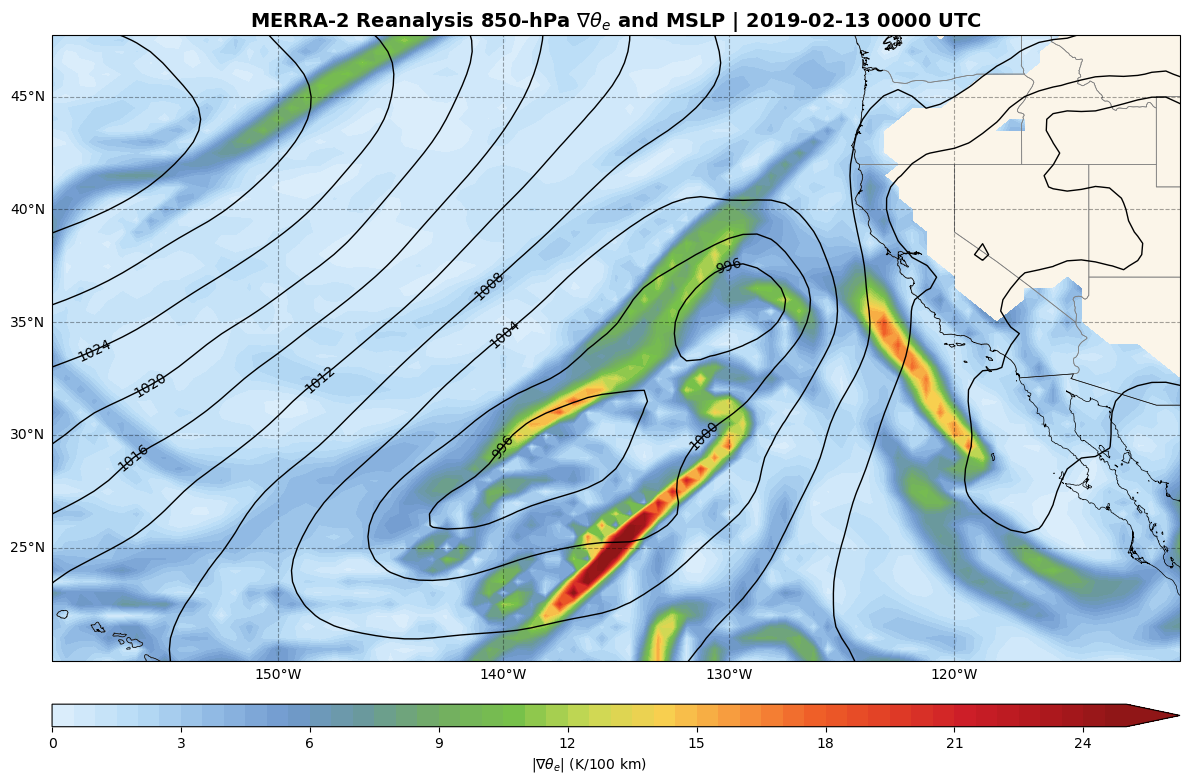

Time taken for iteration 0: 3.10 seconds


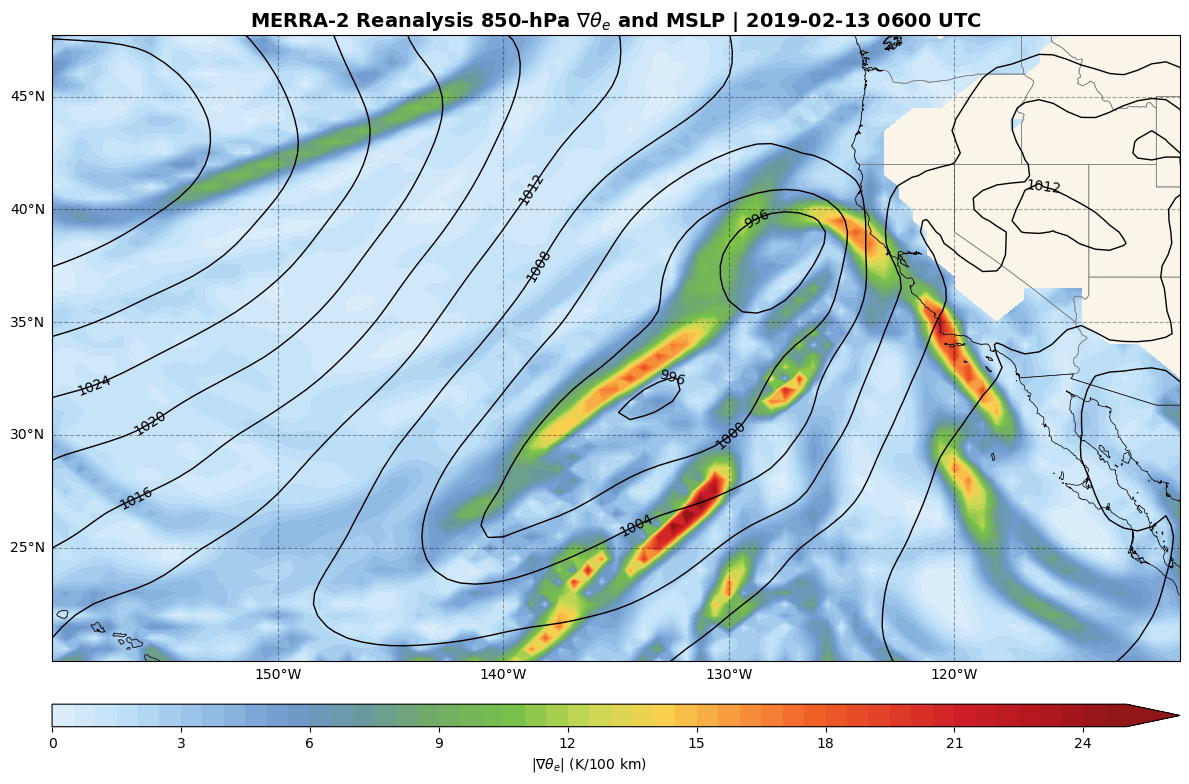

Time taken for iteration 1: 2.96 seconds


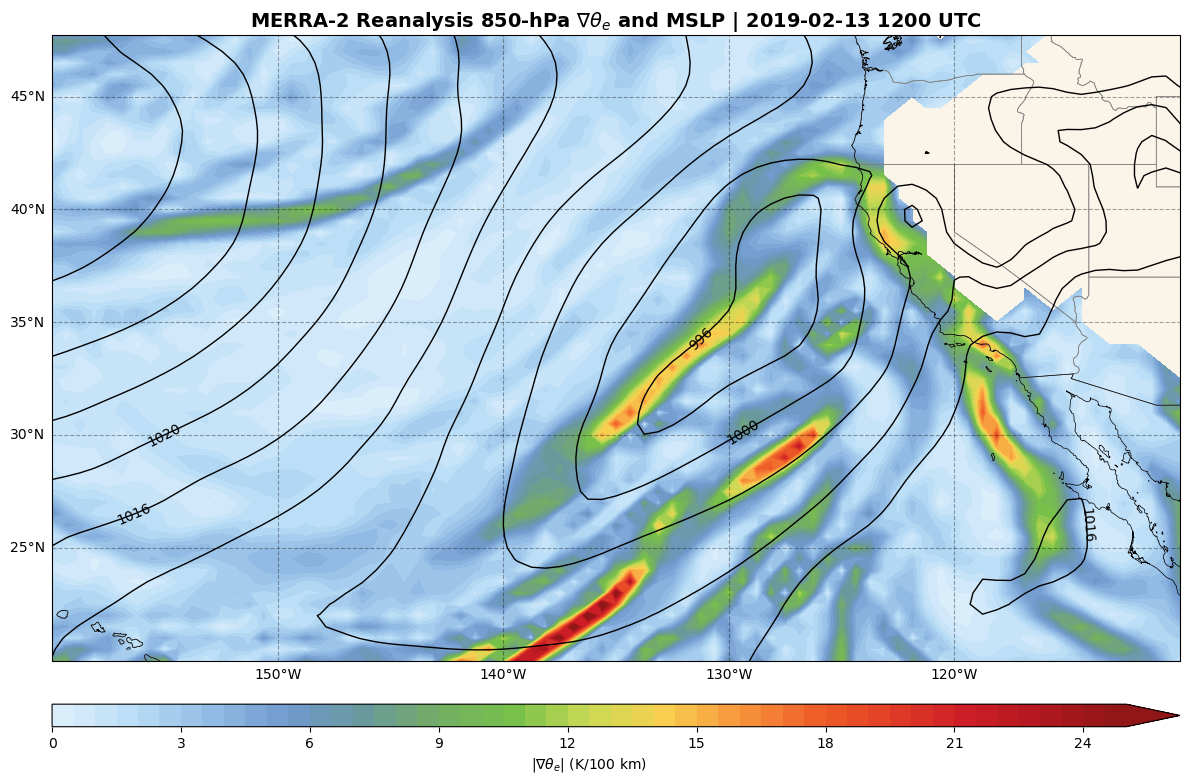

Time taken for iteration 2: 3.19 seconds


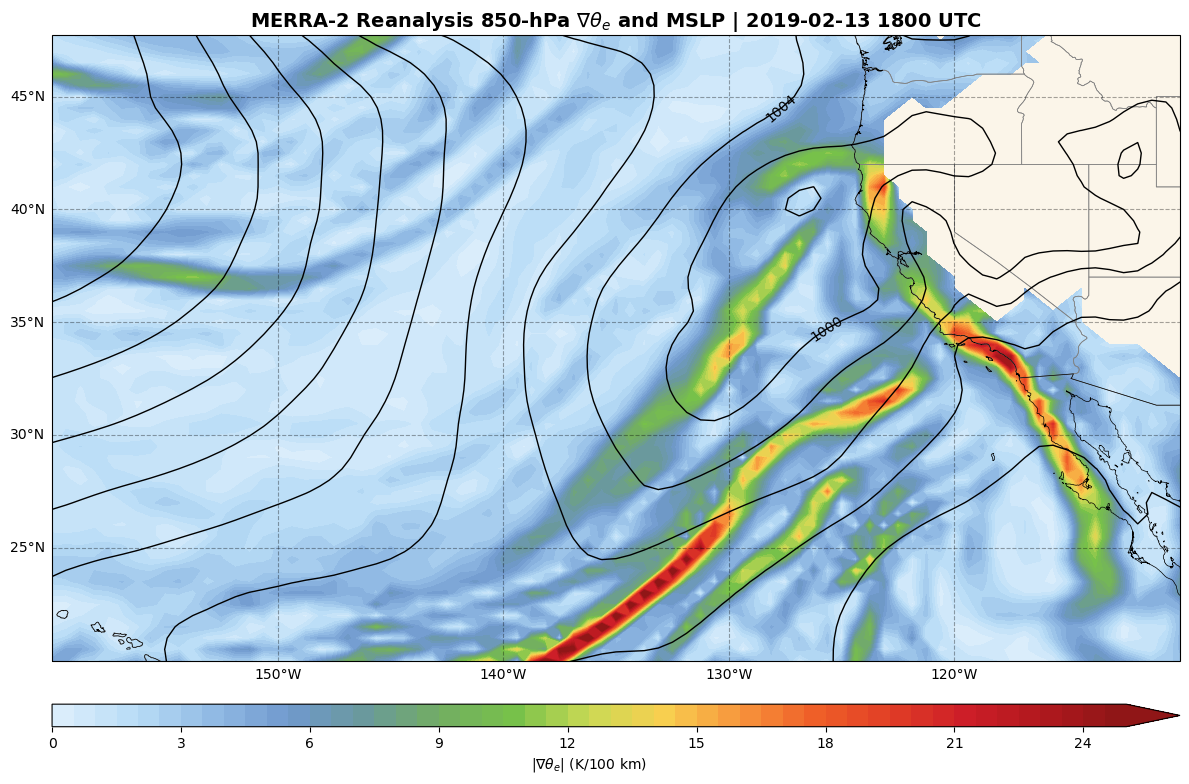

Time taken for iteration 3: 3.13 seconds


In [30]:
if __name__ == '__main__':
    ds = load_dataset()
    directions = {'North': 50, 
                'East': 250, 
                'South': 20, 
                'West': 200} 

    # Convert degrees west to degrees east
    directions['West'] = directions['West'] - 360
    directions['East'] = directions['East'] - 360

    level = 925 # hPa
    plot_grad_thetae(ds, 850, directions)